In [ ]:
# !wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
# !pip install corus 
# !pip install pymorphy2
# !pip install pyLDAvis

In [ ]:
# !apt-get --yes update
# !apt-get --yes install git make cmake build-essential libboost-all-dev
# !apt-get --yes install python-numpy python-pandas python-scipy
# !wget https://bootstrap.pypa.io/get-pip.py
# !python get-pip.py
# !pip install protobuf tqdm wheel
# !git clone --branch=stable https://github.com/bigartm/bigartm.git

In [ ]:
# %cd bigartm

In [ ]:
# !mkdir build

In [ ]:
# %cd build

In [ ]:
# !cmake ..

In [ ]:
# !make

In [ ]:
# !make install

In [ ]:
# !pip install python/bigartm*.whl

In [ ]:
from corus import load_lenta

path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [ ]:
data = [(record.title, record.topic, record.text, record.tags) for record in records]
data[:5]

[('Австрия не\xa0представила доказательств вины российских биатлонистов',
  'Спорт',
  'Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых правил. Об этом сообщил посол России в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии с представителями прокуратуры страны, передает ТАСС. «Действует презумпция невиновности. Каких-либо ограничений свободы передвижения для команды нет», — добавили в посольстве. Международный союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам. Все они продолжат выступление на Кубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12 декабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях с переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список, полиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском Обертиллахе. Обвинения спортсмен назвал бредом, а такж

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool

import artm
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from gensim.models import *
from gensim import corpora

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).ep

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pd.set_option('max_colwidth', -1)

df = pd.DataFrame(data, columns=['title','topic','text','tags'])
df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,title,topic,text,tags
0,Австрия не представила доказательств вины российских биатлонистов,Спорт,"Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых правил. Об этом сообщил посол России в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии с представителями прокуратуры страны, передает ТАСС. «Действует презумпция невиновности. Каких-либо ограничений свободы передвижения для команды нет», — добавили в посольстве. Международный союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам. Все они продолжат выступление на Кубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12 декабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях с переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список, полиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском Обертиллахе. Обвинения спортсмен назвал бредом, а также указал на «охоту на ведьм» в мировом биатлоне. В Австрии прием допинга — уголовное преступление. Максимальное наказание за его употребление — три года тюрьмы.",Зимние виды
1,Обнаружено самое счастливое место на планете,Путешествия,"Сотрудники социальной сети Instagram проанализировали поставленные пользователями смайлики, геолокации и хештеги и опубликовали итоги 2018 года. Об этом сообщается на официальном сайте Instagram. Таким образом, самой счастливой геолокацией Instagram признал Диснейленд в Токио, так как больше всего счастливых смайликов в 2018 году пользователи ставили именно под фотографиями из японского Диснейленда. Также эксперты назвали самый популярный фильтр для лица: им стал фильтр с сердечками на глазах. А, например, самыми часто используемыми хештегами в 2018 году были #metoo, #timesup и #marchforourlives. В ноябре сотрудники британской ассоциации потребителей Which? составили рейтинг самых безопасных стран для путешествий. Специалисты проанализировали 20 самых популярных туристических направлений по четырем критериям: уровень преступности, угроза здоровью, вероятность теракта и стихийных бедствий. Самой безопасной страной по всем параметрам стала Исландия.",Мир
2,В США раскрыли сумму расходов на расследование «российского дела»,Мир,"С начала расследования российского вмешательства в выборы власти США потратили более 25 миллионов долларов. Об этом сообщает Associated Press со ссылкой на отчет Министерства юстиции США. В документе содержатся данные о расходах на следствие с апреля по сентябрь 2018 года. За эти полгода было потрачено 4,6 миллиона долларов, из которых почти 3 миллиона долларов ушли на зарплату сотрудников, 580 тысяч — на поездки и сопутствующие расходы. Ранее Минюст США уже публиковал отчеты о затратах на дело о российском вмешательстве за предыдущие месяцы. 11 декабря расследование спецпрокурора Робера Мюллера показало, что по меньшей мере 14 человек из окружения президента США Дональда Трампа контактировали с россиянами во время его избирательной кампании и последующего переходного периода перед вступлением в должность главы государства. Мюллер с 2017 года ведет дело о якобы российском вмешательстве в американские выборы в 2016-м. Перед ним поставлена задача выяснить, был ли сговор между штабом Трампа и Россией. Кремль и Белый дом отвергают все обвинения. Россию неоднократно обвиняли во вмешательстве в выборы президента США с помощью хакеров. В июне спецслужбы выдвинули заочное обвинение 12 российским разведчикам. По данным спецслужб США, российская разведка использовала две хакерские группировки для взлома серверов Демократической партии.",Политика


In [ ]:
df.shape[0]

739350

In [ ]:
df['topic'].value_counts()

Россия               160518
Мир                  136680
Экономика            79538 
Спорт                64421 
Культура             53803 
Бывший СССР          53402 
Наука и техника      53136 
Интернет и СМИ       44675 
Из жизни             27611 
Дом                  21734 
Силовые структуры    19596 
Ценности             7766  
Бизнес               7399  
Путешествия          6408  
69-я параллель       1268  
Крым                 666   
Культпросвет         340   
                     203   
Легпром              114   
Библиотека           65    
Оружие               3     
ЧМ-2014              2     
Сочи                 1     
МедНовости           1     
Name: topic, dtype: int64

Взять ноутбук с семинара и проанализировать другие тематики
# Количество тематик от 3-х и более

In [ ]:
topics = ['Мир', 'Дом', 'Ценности', 'Бизнес']

df = df[df['topic'].isin(topics)]
df.dropna(inplace=True)
df.head(3)

,title,topic,text,tags
2,В США раскрыли сумму расходов на расследование «российского дела»,Мир,"С начала расследования российского вмешательства в выборы власти США потратили более 25 миллионов долларов. Об этом сообщает Associated Press со ссылкой на отчет Министерства юстиции США. В документе содержатся данные о расходах на следствие с апреля по сентябрь 2018 года. За эти полгода было потрачено 4,6 миллиона долларов, из которых почти 3 миллиона долларов ушли на зарплату сотрудников, 580 тысяч — на поездки и сопутствующие расходы. Ранее Минюст США уже публиковал отчеты о затратах на дело о российском вмешательстве за предыдущие месяцы. 11 декабря расследование спецпрокурора Робера Мюллера показало, что по меньшей мере 14 человек из окружения президента США Дональда Трампа контактировали с россиянами во время его избирательной кампании и последующего переходного периода перед вступлением в должность главы государства. Мюллер с 2017 года ведет дело о якобы российском вмешательстве в американские выборы в 2016-м. Перед ним поставлена задача выяснить, был ли сговор между штабом Трампа и Россией. Кремль и Белый дом отвергают все обвинения. Россию неоднократно обвиняли во вмешательстве в выборы президента США с помощью хакеров. В июне спецслужбы выдвинули заочное обвинение 12 российским разведчикам. По данным спецслужб США, российская разведка использовала две хакерские группировки для взлома серверов Демократической партии.",Политика
3,Хакеры рассказали о планах Великобритании заминировать Севастополь,Мир,"Хакерская группировка Anonymous опубликовала новые документы о деятельности британского аналитического центра Integrity Initiative. Из материалов следует, что центр получает финансирование от некого Института государственного управления под руководством Кристофера Доннелли. Хакеры выложили в открытый доступ его паспорт, резюме, а также сведения о его связях с Министерством обороны Великобритании. Согласно документам, в 2014 году Доннелли выдвинул ряд предложений британским властям в связи с ситуацией в Крыму. В частности, он планировал заминировать Севастопольскую бухту, окружить полуостров войсками, а также уничтожить оставшиеся в Крыму самолеты «в знак серьезности намерений». После публикации заметки часть документов, на которые члены группировки ссылаются в своем расследовании, была удалена. Также хакеры утверждают, что Доннелли был инициатором расследования «российского вмешательства» в референдум о независимости в Каталонии. Он пригласил членов испанского отделения Integrity Initiative в качестве свидетелей. По данным группировки, Доннелли получал деньги на это от Министерства иностранных дел Великобритании. «Британская разведка платила собственным агентам за фальшивые доказательства вмешательства России в каталонский референдум, а затем приказала им солгать в парламенте с целью убедить их предпринять антироссийские шаги», — пишут хакеры. Члены Anonymous опубликовали только часть документов, связанных с деятельностью Кристофера Доннелли. Если расследование Великобритании в отношении Integrity Initiative не даст результатов, они пригрозили выложить новые доказательства того, что Доннелли тесно взаимодействует с британскими спецслужбами и использует свое положение для влияния на политику страны. 23 ноября Anonymous впервые опубликовали документы Integrity Initiative, которые содержат инструкции по борьбе с российской пропагандой и примеры дезинформации со стороны Москвы. Хакеры утверждают, что этот проект финансируется правительством Великобритании и работает сразу в нескольких странах, в том числе в Германии, Франции, Испании.",Общество
6,Полицейские из Солсбери описали одеревеневшего Скрипаля,Мир,"Полицейские Алекс Коллинс и Трейси Холлоуэй, оказавшие первую помощь Сергею Скрипалю и его дочери Юлии, рассказали подробности того дня, когда обнаружили их. Констебль и сержант поделились воспоминаниями с газетой The Guardian. По словам стражей порядка, их дежурство началось за час с четвертью до того, как в полицию поступило соо

In [ ]:
df.shape[0]

173579

In [ ]:
morph = MorphAnalyzer()
words_regex = re.compile('\w+')
stopwords_list = stopwords.words('russian')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-20-b610e06cf881>:2: DeprecationWarning: invalid escape sequence \w
  words_regex = re.compile('\w+')
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2

In [ ]:
df['text'].iloc[0]

'С начала расследования российского вмешательства в выборы власти США потратили более 25 миллионов долларов. Об этом сообщает Associated Press со ссылкой на отчет Министерства юстиции США. В документе содержатся данные о расходах на следствие с апреля по сентябрь 2018 года. За эти полгода было потрачено 4,6 миллиона долларов, из которых почти 3\xa0миллиона долларов ушли на зарплату сотрудников, 580 тысяч — на поездки и сопутствующие расходы. Ранее Минюст США уже публиковал отчеты о затратах на дело о российском вмешательстве за предыдущие месяцы. 11 декабря расследование спецпрокурора Робера Мюллера показало, что по меньшей мере 14 человек из окружения президента США Дональда Трампа контактировали с россиянами во время его избирательной кампании и последующего переходного периода перед вступлением в должность главы государства. Мюллер с 2017 года ведет дело о якобы российском вмешательстве в американские выборы в 2016-м. Перед ним поставлена задача выяснить, был ли сговор между штабом 

In [ ]:
df = df.sample(10_000)
df['topic'].value_counts()

Мир         7868
Дом         1298
Ценности    421 
Бизнес      413 
Name: topic, dtype: int64

In [ ]:
df['text'] = list(tqdm(
    map(preprocess, df['text']), 
    total=df.shape[0]
))
df.head(3)

,title,topic,text,tags
460769,В Бангкоке погибли два манифестанта,Мир,"[власть, таиланд, заявить, погибнуть, ход, антиправительственный, выступление, это, сообщать, afp, понедельник, апрель, таиландский, полиция, особо, отмечать, двое, участник, демонстрация, погибнуть, перестрелка, который, устроить, местный, житель, полицейский, участвовать, отметить, понедельник, апрель, ведущий, мировой, сми, сообщить, подавление, беспорядок, бангкок, полицейский, открыть, огонь, манифестант, поскольку, начать, забрасывать, стража, порядок, камень, бутылка, зажигательный, смесь, официальный, версия, понедельник, центр, бангкок, местный, житель, число, сторонник, бывший, премьера, страна, таксина, чинават, установить, баррикада, вокруг, здание, правительство, защититься, полиция, именно, сторонник, чинават, данные, полиция, застрелить, мужчина, имя, сообщаться, возраст, год, второй, год, сотрудник, центральный, госпиталь, бангкок, сообщить, кровь, погибший, летний, мужчина, обнаружить, след, алкоголь, ранее, сообщаться, пострадать, ход, ...]",Все
634810,В Иордании в ДТП погибли семь британских туристов,Мир,"[иордания, перевернуться, автобус, турист, великобритания, сообщать, sky, news, инцидент, произойти, около, развалины, город, пётр, являться, излюбить, место, путешественник, именно, сюда, пятница, должный, прибыть, британский, принц, чарльз, гостить, иордания, данные, британский, посольство, ближневосточный, страна, результат, автокатастрофа, семь, человек, погибнуть, всё, пострадать, доставить, близкий, армейский, госпиталь, откуда, переплавить, столица, иордания, амман, представитель, дипломатический, корпус, назвать, случиться, ужасный, происшествие, слово, посольство, продолжать, ждать, последний, информация, место, происшествие, причина, трагедия, пока, неизвестный, предварительный, данные, автобус, турист, столнкунль, легковой, автомобиль, съехать, трасса, перевернуться]",Все
20699,Девушки начали носить купальник вверх тормашками,Ценности,"[австралийский, бренд, производитель, пляжный, одежда, cantik, предложить, девушка, носить, бикини, необычный, образ, сообщать, the, sun, тренд, задать, итальянский, модель, валентина, фрадеград, модель, надеть, топ, купальник, вверх, тормашки, повязать, бретелька, вокруг, тело, нижний, завязка, затянуть, грудь, публикация, valentina, fradegrada, valentinafradegradafans, июн, pdt, администратор, instagram, аккаунт, cantik, попросить, подписчица, рассказать, думать, идея, многие, восторг, назвать, способ, мгновенный, увеличение, грудь, фрадеград, завести, отдельный, страница, название, upsidedown, bikini, official, девушка, делиться, фотография, надеть, вверх, тормашки, топ, июнь, бразильский, модель, софия, ресинга, совместно, аргентинский, дизайнер, мери, ракаучить, выпустить, коллекция, увеличивать, ягодица, пляжный, одежда, mery, playa, sofia, resing, слово, ресинга, весь, жизнь, мечтать, свой, уникальный, линия, ...]",Стиль


In [ ]:
dictionary = corpora.Dictionary(df['text'])
dictionary.filter_extremes(no_below=10, no_above=0.9)
dictionary.save('lenta.dict')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('lenta.model', corpus)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


# Сравните и сделайте выводы, реализаций gensim/bigartm и ещё возьмите sklearn реализацию метода LDA

In [ ]:
# LDA

lda = ldamodel.LdaModel(
    corpus, 
    id2word=dictionary, 
    num_topics=7, 
    chunksize=50, 
    update_every=1, 
    passes=2
)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.033*"год" + 0.016*"который" + 0.013*"суд" + 0.009*"власть" + 0.009*"это" + 0.007*"дело" + 0.006*"сообщать" + 0.006*"решение" + 0.005*"право" + 0.005*"человек"'),
 (1,
  '0.022*"президент" + 0.017*"страна" + 0.013*"министр" + 0.012*"сша" + 0.011*"россия" + 0.010*"заявить" + 0.010*"это" + 0.009*"глава" + 0.008*"который" + 0.008*"свой"'),
 (2,
  '0.020*"военный" + 0.012*"ирак" + 0.009*"израиль" + 0.009*"американский" + 0.009*"сша" + 0.008*"аль" + 0.008*"израильский" + 0.008*"территория" + 0.007*"боевик" + 0.007*"это"'),
 (3,
  '0.027*"год" + 0.019*"тысяча" + 0.015*"миллион" + 0.015*"компания" + 0.014*"доллар" + 0.014*"метр" + 0.012*"рубль" + 0.012*"москва" + 0.012*"проект" + 0.012*"квадратный"'),
 (4,
  '0.029*"процент" + 0.024*"год" + 0.015*"компания" + 0.013*"это" + 0.009*"новый" + 0.007*"также" + 0.007*"продажа" + 0.007*"который" + 0.006*"программа" + 0.006*"первый"'),
 (5,
  '0.021*"человек" + 0.013*"сообщать" + 0.011*"город" + 0.011*"погибнуть" + 0.010*"результат" + 0.010*"

In [ ]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

Персплексия:  0.00044670264679190686


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.477899033607136


In [ ]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v').get_coherence())

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sc

# Попробуйте выявить оптимальное количество тем и вывести сами тематики

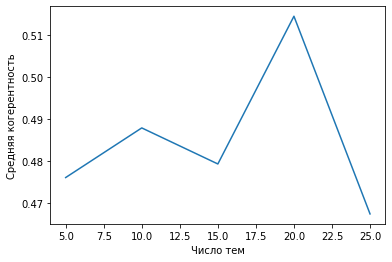

In [ ]:
plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [ ]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

## Вывод:
Оптимальное число тем - 15

In [ ]:
# BigARTM

df['text'] = df['text'].apply(lambda x: ' '.join(x))
df.head(3)

,title,topic,text,tags
460769,В Бангкоке погибли два манифестанта,Мир,власть таиланд заявить погибнуть ход антиправительственный выступление это сообщать afp понедельник апрель таиландский полиция особо отмечать двое участник демонстрация погибнуть перестрелка который устроить местный житель полицейский участвовать отметить понедельник апрель ведущий мировой сми сообщить подавление беспорядок бангкок полицейский открыть огонь манифестант поскольку начать забрасывать стража порядок камень бутылка зажигательный смесь официальный версия понедельник центр бангкок местный житель число сторонник бывший премьера страна таксина чинават установить баррикада вокруг здание правительство защититься полиция именно сторонник чинават данные полиция застрелить мужчина имя сообщаться возраст год второй год сотрудник центральный госпиталь бангкок сообщить кровь погибший летний мужчина обнаружить след алкоголь ранее сообщаться пострадать ход беспорядок появиться официальный уточнить дать весь получить ранение человек среди полицейский напомнить таиландский премьер министр aпхисит ветчачивый заявить понедельник день правительственный войско подавить беспорядок бангкок ситуация находиться полный контроль апрель год таиланд возобновиться массовый выступление сторонник бывший премьера страна таксина чинават свергнуть год результат военный переворот чинават считаться лидер протестовать манифестант потребовать отставка правительство aпхисит ветчачивый апрель бангкок окрестность ввести чрезвычайный положение военный демонстрант пройти столкновение полицейский охранять здание правительство апрель открыть манифестант огонь,Все
634810,В Иордании в ДТП погибли семь британских туристов,Мир,иордания перевернуться автобус турист великобритания сообщать sky news инцидент произойти около развалины город пётр являться излюбить место путешественник именно сюда пятница должный прибыть британский принц чарльз гостить иордания данные британский посольство ближневосточный страна результат автокатастрофа семь человек погибнуть всё пострадать доставить близкий армейский госпиталь откуда переплавить столица иордания амман представитель дипломатический корпус назвать случиться ужасный происшествие слово посольство продолжать ждать последний информация место происшествие причина трагедия пока неизвестный предварительный данные автобус турист столнкунль легковой автомобиль съехать трасса перевернуться,Все
20699,Девушки начали носить купальник вверх тормашками,Ценности,австралийский бренд производитель пляжный одежда cantik предложить девушка носить бикини необычный образ сообщать the sun тренд задать итальянский модель валентина фрадеград модель надеть топ купальник вверх тормашки повязать бретелька вокруг тело нижний завязка затянуть грудь публикация valentina fradegrada valentinafradegradafans июн pdt администратор instagram аккаунт cantik попросить подписчица рассказать думать идея многие восторг назвать способ мгновенный увеличение грудь фрадеград завести отдельный страница название upsidedown bikini official девушка делиться фотография надеть вверх тормашки топ июнь бразильский модель софия ресинга совместно аргентинский дизайнер мери ракаучить выпустить коллекция увеличивать ягодица пляжный одежда mery playa sofia resing слово ресинга весь жизнь мечтать свой уникальный линия купальник поэтому разработка коллекция продумать каждый деталь сделать эластичный вставка нижний часть купальник приподнимать ягодица сплющивать рассказать летний модель,Стиль


In [ ]:
def convert_to_vw_format(index, row):
    return f'doc{index} {row.text} |topic {row.topic}'

In [ ]:
with open('lenta_wv.wv', 'w') as f:
    for index, row in df.iterrows():
        vw_string = convert_to_vw_format(index, row)
        f.write(vw_string)
        f.write('\n')

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='lenta_wv.wv', 
                                        data_format='vowpal_wabbit',
                                        target_folder='lenta_batches')

In [ ]:
lda = artm.LDA(num_topics=10, alpha=0.1, beta=0.001, 
               cache_theta=True,
               num_document_passes=5, 
               dictionary=batch_vectorizer.dictionary)
lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
lda.perplexity_value

np.log(lda.perplexity_last_value)

7.7832958317911

In [ ]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['год', 'компания', 'это', 'процент', 'миллиард', 'россия', 'который', 'также', 'миллион', 'российский']
Topic #1: ['год', 'тысяча', 'процент', 'миллион', 'доллар', 'метр', 'квадратный', 'рубль', 'компания', 'москва']
Topic #2: ['который', 'свой', 'год', 'штат', 'сообщать', 'человек', 'это', 'заявить', 'сша', 'обама']
Topic #3: ['сша', 'который', 'страна', 'президент', 'американский', 'это', 'заявить', 'год', 'оон', 'иран']
Topic #4: ['страна', 'год', 'это', 'израиль', 'правительство', 'министр', 'который', 'заявить', 'палестинский', 'власть']
Topic #5: ['россия', 'это', 'сша', 'российский', 'который', 'заявить', 'украина', 'самолёт', 'корея', 'военный']
Topic #6: ['год', 'президент', 'суд', 'который', 'это', 'бывший', 'выборы', 'свой', 'партия', 'дело']
Topic #7: ['человек', 'город', 'погибнуть', 'сообщать', 'результат', 'произойти', 'который', 'находиться', 'это', 'данные']
Topic #8: ['человек', 'который', 'тысяча', 'год', 'это', 'сообщать', 'около', 'время', 'находиться', 

In [ ]:
batch_vectorizer.dictionary.filter(min_tf=10, max_tf=5000)

artm.Dictionary(name=b996d236-b527-4953-803c-20db047f16e4, num_entries=10259)

In [ ]:
plsa = artm.ARTM(num_topics=10, dictionary=batch_vectorizer.dictionary)

plsa.scores.add(artm.PerplexityScore(name='lenta_perplexity_score', dictionary=batch_vectorizer.dictionary))
plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

plsa.score_tracker['lenta_perplexity_score'].value

[2618.6748046875,
 946.2960205078125,
 880.7960815429688,
 785.2857666015625,
 720.708251953125,
 682.6580810546875,
 657.130859375,
 639.5419311523438,
 627.7576293945312,
 619.8058471679688,
 614.1566162109375,
 609.91796875,
 606.6043090820312,
 604.0242919921875,
 602.0722045898438,
 600.5535278320312,
 599.3143310546875,
 598.2752685546875,
 597.3867797851562,
 596.5934448242188]

In [ ]:
for topic_name in plsa.topic_names:
    print (topic_name + ': ', plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['компания', 'миллиард', 'доллар', 'миллион', 'банк', 'процент']
topic_1:  ['процент', 'тысяча', 'рубль', 'миллион', 'квартира', 'доллар']
topic_2:  ['президент', 'американский', 'обама', 'партия', 'заявить', 'штат']
topic_3:  ['проект', 'строительство', 'москва', 'компания', 'центр', 'площадь']
topic_4:  ['военный', 'ирак', 'израиль', 'аль', 'израильский', 'заявить']
topic_5:  ['самолёт', 'находиться', 'аэропорт', 'корея', 'борт', 'северный']
topic_6:  ['суд', 'дело', 'бывший', 'обвинение', 'президент', 'власть']
topic_7:  ['погибнуть', 'город', 'результат', 'произойти', 'пострадать', 'полиция']
topic_8:  ['россия', 'российский', 'заявить', 'президент', 'министр', 'украина']
topic_9:  ['полиция', 'женщина', 'мужчина', 'летний', 'дом', 'бренд']
